![Banner](./../0-Course-info/images/bannerSoB.png)

# Work with Ocean Color Products of Primary production Time Series
## Purpose  


**Authors: Egor Prikaziuk and Suhyb Salama, ITC**  


The exercise is a follow up on the exercises: [exercise 1.1](./../1-Ocean-Climate/1.1_work_OC_TS.ipynb), [exercise 1.2](./../1-Ocean-Climate/1.2_work_OC_TS.ipynb) and [exercise 2.2](./../2-Water-pollution/2.2_WQ_AnomaliesS2.ipynb).


## Prerequisites
- You should have an account in Google Earth Engine. If not done yet please [sign up now](https://earthengine.google.com/signup/).
- You should have worked out the above mention exercises. 

## What you will learn
1. Access Ocean Color products on GEE;
2. Convert Ocean Color products to primary production products;
3. Perform a temporal averaging and visualize the results;
4. Extract time series with PANDAS;
5. Perform comparison between different PP models.

## What will you achieve
At the end of this exercise you will be able to apply an algorithm to derive oceanic primary productivity (PP) and perform advanced time series analysis on the results of area averaged PP.

## PART 1: Repetition 

### Initialize the authentication process.
This process will let you log in with your user name and password
*  You may skip **ee.Authenticate()** step when you come here straight from the previous exercise because the authentication will be still valid.  
* This is taken care for using the **Try -> Except** statement 

In [3]:
import ee

In [4]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Enter verification code:  4/1AbUR2VM9b6OvGuDcL-AXAlNbgKo2zgVPRvsn2TXYQLU2zIAWMPWhVvfhu74



Successfully saved authorization token.


### Import Google Earth mapping capabilities

More information on the functionality of the *geemap* python package can be found at this [link](https://geemap.org/), which includes a [cheat sheet](https://geemap.org/cheatsheet/), [tutorials](https://geemap.org/tutorials/) and [book](https://book.geemap.org/) with valuable resources. 
The syntax of many of the Google Earth Engine functions that are also callable with the *geemap* site package can be found under the [Client Libraries](https://developers.google.com/earth-engine/apidocs/).

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geemap.eefolium as geemap
import geemap.colormaps as cm
Map = geemap.Map()

### Data Access
Get access to [MODIS product of Ocean Color](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#description). 

In [7]:
MODIS_OC_DS = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI")


#### Interrogate 
get some information on the data set of *MODIS_OC_DS*

- Select one layer and list the band names
- The [descriptions of bands](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#bands) provides details on the content of the data set.

In [8]:
first_image = MODIS_OC_DS.first()
Bname = first_image.get('system:band_names')
print('system:band_names', Bname.getInfo())

system:band_names ['chlor_a', 'nflh', 'poc', 'Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678', 'sst']


#### Data filtering
- Select Chlorophyll a concentration products *chlor_a* and Sea Surface Temperature *sst*, and filter the product to staring and ending times


In [9]:
selected_bands = ['chlor_a', 'sst']

sY=2003
sM=1
sD=1
eY=2021
eM=12
eD =31

start_date = ee.Date.fromYMD(sY, sM, sD)
end_date   = ee.Date.fromYMD(eY, eM, eD)

Mod_DS = MODIS_OC_DS.select(selected_bands).filter(ee.Filter.date(start_date, end_date))

* Count how many images

In [10]:
count = Mod_DS.size()
valCount=count.getInfo()
print('Numbre of images is : ', str(valCount)+'\n')

Numbre of images is :  6849



### Time aggregation

#### Compute the monthly mean
To bin the daily data into monthly, we need two *for loops*, one for the years and one for the months. An Alternative to using *for loops* is to  apply the *.map* functionality twice, first on years and second on months.

The script below shows a nested functions of two application of *.map*. The core for binning daily to monthly data is the function **createMean**.

**createMean**: for a specific year, it iterate on the months, whereby per month the daily data are summed. The for loop on the *years* would iterate on the years. this function is encapsulated by the **getMonthlyMean** which run **createMean** on months. Later the **getMonthlyMean** is run on years.


- Create a series of years and months to loop on

In [11]:
years = ee.List.sequence(sY, eY)
months = ee.List.sequence(sM, eM)

- Define the functions **getMonthlyMean** and **createMean**

In [12]:
def getMonthlyMean(iy):
    def createMean(im):
        sDate = ee.Date.fromYMD(iy, im, sD)
        eDate = sDate.advance(1, 'month')
        monthFiltered = Mod_DS.filter(ee.Filter.date(sDate, eDate))
        msum = monthFiltered.reduce(ee.Reducer.mean())
        return msum.set({
            'system:time_start': sDate.millis(),
            'system:time_end': eDate.millis(),
            'year': iy,
            'month': im,
            'date': sDate.millis()})
    return months.map(createMean)

##### Apply monthly binning 
Run the monthly binning function and visualize the first month and investigate the results:
1. count the number of images in the image collection resulting from the function **getMonthlyMean**
2. add the the first image and visualize, use the *'MonthlyChl-a*  and *'MonthlySST* as the name of the layers.

In [13]:
%%time
monthlyChlaSST = ee.ImageCollection.fromImages(years.map(getMonthlyMean).flatten())

CPU times: user 13.6 ms, sys: 5.57 ms, total: 19.1 ms
Wall time: 18.2 ms


### Time series extraction 
To work with a time series you can extract a point or a region. Here we will extract the time series of a an area.
To be able to do so the following steps are needed
1. Select the region of interest (ROI);
2. Clip the image to the ROI and average over the region;
3. Extract the time series of the areal average;


#### Spatial Sub set
- Load the bounding box in the the Mediterranean sea
- You can easily create a geojson file using the [interactive geojson map](https://geojson.io/)

In [14]:
#seas_shapefile_path = "./../0-Course-info/data/Geojason/boxMed.geojson"
#seas =  geemap.geojson_to_ee(seas_shapefile_path)
seas = ee.Geometry.Rectangle([20, 30, 40, 45])

- The function **getTM4RoI** will iterate on the images in an image collection and use the nested function **iter_func** to extract the date and calculate the mean of a region using **.reduceRegion.** The function will return these values as a list of three columns ['Dates', 'Chla' ,'SST'].

In [15]:
def getTM4RoI(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"))
        stat= image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = seas,
            scale = 5000,
            maxPixels=1e15)      
        newlist = ee.List(newlist)
        res = newlist.add([date, stat])
        return ee.List(res)
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).getInfo())

In [16]:
%%time
inList = getTM4RoI(monthlyChlaSST)  # takes time

CPU times: user 17 ms, sys: 883 µs, total: 17.9 ms
Wall time: 975 ms


#### Convert to a Data Frame
The function **Convert2TM_DF** will take the generated list from **getTM4RoI** and convert to a *Pandas Data frame* with recognizable dates. This step will make time series analysis much easier. *Pandas Data frame* is a python library and is outside GEE.

In [17]:
def Convert2TM_DF(inList):
    newList =[]
    for i, item in enumerate(inList):
        if np.any(item[1].get('chlor_a_mean')):
            newList.append([item[0],item[1].get('chlor_a_mean'),item[1].get('sst_mean')])
    DF=pd.DataFrame(newList,columns=['Dates' ,'Chla','sst'])
    datetime_series = pd.to_datetime(DF['Dates'],format='%Y%m%d')
    DF.drop('Dates', axis=1, inplace=True)
    DF.set_index(datetime_series, inplace=True,drop=True)
    DF.mask(DF.eq('None')).dropna()
    return DF

#### Extract time series on monthly climatology
To do so, apply the function **getTM4RoI** first and then use its output in the function **Convert2TM_DF**
Or you can do it in one run *res=Convert2TM_DF(getTM4RoI(ImgCol,Name))*.

In [29]:
TM_ChlaSST  = Convert2TM_DF(inList)

In [30]:
# TM_ChlaSST.to_csv('SoB_chla_sst.csv')
# TM_ChlaSST = pd.read_csv('SoB_chla_sst.csv', index_col=0, parse_dates=True)

##### Visualize the monthly mean with Pandas capabilities

Text(0, 0.5, 'SST [$^o$C]')

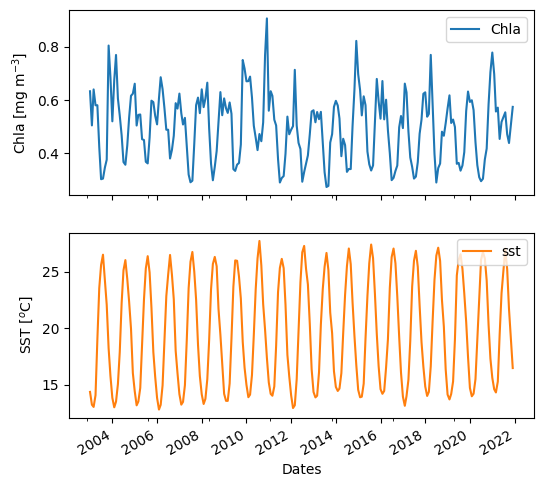

In [33]:
axes= TM_ChlaSST.plot(subplots=True, figsize=(6, 6)); plt.legend(loc='upper right')
axes[0].set_ylabel('Chla [mg m$^{-3}$]')
axes[1].set_ylabel('SST [$^o$C]')

# PART 1: Primary production 
## Empirical model (Eppley's model)
The [Eppley et al. (1985) model](https://doi.org/10.1093/plankt/7.1.57) is an empirical model that estimates prmary productivity as a function of chlorophyll-a:
  
$$\log PP = 3+ 0.5 \log Chla$$

 The unit is mg Carbon per square meter per day 



In [34]:
PP = 10** (3+0.5* np.log(TM_ChlaSST.Chla))

### Vertically generalized production model (VGPM)
The following code calculates primary production using the [Behrenfeld and Falkowski (1997) model](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lo.1997.42.1.0001). 

$$PP_{eu}= 0.66125\times P^B_{opt}\times\frac{E_0}{E_0+4.1}\times Z_{eu}\times C_{sat}\times D_{irr}$$


where,    
$PP_{eu}$: Daily C fixation integrated from the surface to $Z_{eu}$, in [mg C m$^{-2}$]  
$P^B_{opt}$: Optimal C fixation rate within a water column  [mg C (mg Chl)${-1}$ h$^{-l}$]   
${E_0}$: Sea surface daily average PAR in [mol quanta m$^{-2}$], or solar PAR irradiance in [W m$^{-2}$]  
$Z_{eu}$ Euphotic depth in [m]  
$C_{sat}$: Surface concentration of chlorophyll-a in [mg m$^{-3}$]  
$D_{irr}$ Photo-period (daily light) in [hours]  
It uses MODIS SST products to estimate $P^B_{opt}$ and chlorophyll products to estimate the *Euphotic Depth* (see for example [Lee et al., 2007](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2006JC003802)) for a specified region and time period. It then calculates the solar radiation and photosynthetically active radiation for the specified region. Finally, it uses the retrieved data to compute the primary production.

 [Behrenfeld and Falkowski (1997) model](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lo.1997.42.1.0001) approximated $P^B_{opt}$ as 7th degree polynomials of SST:
$$P^B_{opt}= w_0+\sum_{i=1}^{i=7}w_i\times SST^i$$

The weights are given below in the code.

In [35]:
sst=TM_ChlaSST.sst.values
Popt = - 3.27e-8*sst**7 \
       + 3.4132e-6*sst**6 \
       - 1.348e-4*sst**5 \
       + 2.46e-3*sst**4  \
       - 0.0205*sst**3 \
       + 0.0617*sst**2 \
       + 0.2749*sst \
       + 1.2956

From [Morel et al., 2007](https://doi.org/10.1016/j.rse.2007.03.012) we have:
$$\log_{10}Z_{eu}=1.524-0.436X-0.0145X^2+0.0186X^3$$ 
where $X=\log_{10} Chla$

In [36]:
X=np.log10(TM_ChlaSST.Chla.values)
zeu=10**(1.524-0.436*X-0.0145*X**2+0.0186*X**3)  # m

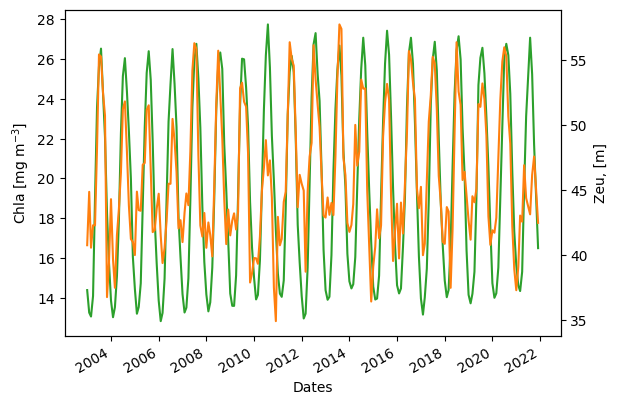

In [37]:
TM_ChlaSST['zeu'] = zeu
TM_ChlaSST['Popt'] = Popt
TM_ChlaSST['PP'] = PP


ax = TM_ChlaSST.sst.plot(c='tab:green')
ax.set_ylabel('Chla [mg m$^{-3}$]')

ax2 = ax.twinx()
TM_ChlaSST.zeu.plot(ax=ax2, c='tab:orange')
ax2.set_ylabel('Zeu, [m]');


### PAR: photosynthetically active radiation

From Climate Forecast System (CFS) https://developers.google.com/earth-engine/datasets/catalog/NOAA_CFSV2_FOR6H

In [38]:
par = ee.ImageCollection('NOAA/CFSV2/FOR6H').filterDate(start_date, end_date).select('Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average')

50 seconds for 1.5 years

It's too long to process in parallel. Also, there are too many pixels. If we do it directly GEE would throw an error

Luckily, we can use the **map-reduce paradigm**

In [42]:
from datetime import datetime



In [44]:
%%time
year_start = pd.to_datetime(datetime(sY, sM, sD))
n_years = eY-sY

tmRoi = []

def aggregate_par(image):
    """" 
    Reducing function. 
    Works with a single image, reduces it to a number. 
    To be mapped over ImageCollection
    """
    return ee.Feature(None, 
                      image.reduceRegion(reducer = ee.Reducer.mean(),
                                         geometry = seas,
                                         scale = 5000,
                                         maxPixels=1e15)
                     )


for _ in range(n_years):
    print(year_start)
    year_end = year_start + pd.DateOffset(years=1)
    
    par = ee.ImageCollection('NOAA/CFSV2/FOR6H')\
        .filterDate(year_start, year_end)\
        .select('Downward_Short-Wave_Radiation_Flux_surface_6_Hour_Average')
    
    features = par.map(aggregate_par)
    df_i = pd.json_normalize(features.getInfo()['features'])
    tmRoi.append(df_i)

    year_start = year_end


2003-01-01 00:00:00
2004-01-01 00:00:00
2005-01-01 00:00:00
2006-01-01 00:00:00
2007-01-01 00:00:00
2008-01-01 00:00:00
2009-01-01 00:00:00
2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00
2017-01-01 00:00:00
2018-01-01 00:00:00
2019-01-01 00:00:00
2020-01-01 00:00:00
CPU times: user 705 ms, sys: 38.9 ms, total: 744 ms
Wall time: 26.5 s


In [45]:
tmRoi = pd.concat(tmRoi)

In [46]:
tmRoi.index = pd.to_datetime(tmRoi['id'], format='%Y%m%d%H')
tmRoi = tmRoi.drop(columns=['type', 'geometry', 'id'])
tmRoi.columns = ['sw_in']

In [47]:
tmRoi.head(2)

,sw_in
id,
2003-01-01 00:00:00,3.19073
2003-01-01 06:00:00,220.81455


<AxesSubplot: xlabel='id'>

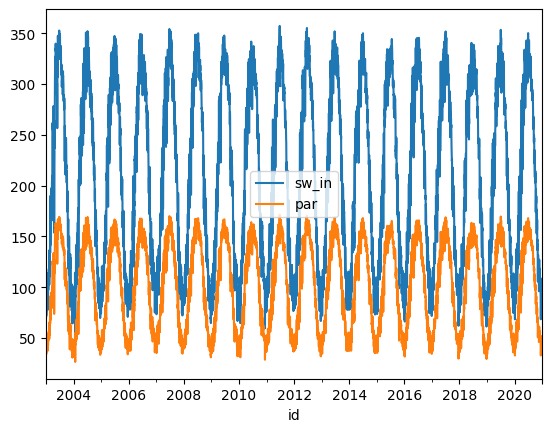

In [48]:
tmRoi_dd = tmRoi.resample('D').mean()
tmRoi_dd['par'] = tmRoi_dd.sw_in * 0.48
tmRoi_dd.plot()

<AxesSubplot: xlabel='id'>

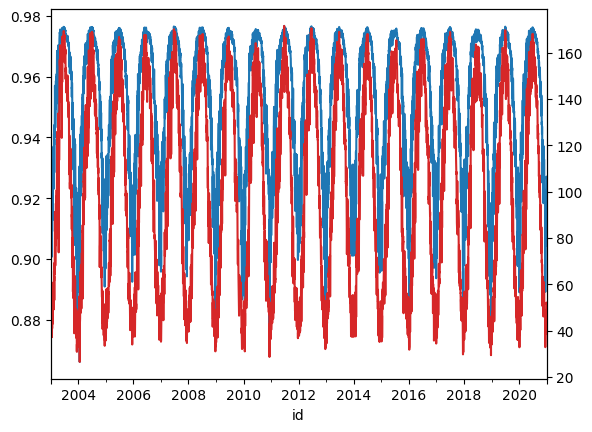

In [49]:
ax = (tmRoi_dd['par'] / (tmRoi_dd['par'] + 4.1)).plot()
tmRoi_dd.par.plot(ax=ax.twinx(), c='tab:red')

In [50]:
TM_ChlaSST = TM_ChlaSST.join(tmRoi_dd.par)

### Photo-period (daily light) 

can be computed based on location, and date.
For that we use the astronomy Python package [EPHEM](https://pypi.org/project/ephem/).

In [51]:
import ephem
def get_dailyPhotoPeriod(lat,long,date):
    observer = ephem.Observer()
    observer.lat = lat  # Latitude of the observer in decimal degrees
    observer.lon = long  # Longitude of the observer in decimal degrees
    # Set the observer date (UTC timezone)
    observer.date = date
    # Calculate the hours of daylight
    sunrise = observer.previous_rising(ephem.Sun())
    sunset = observer.previous_setting(ephem.Sun())
    daylight_hours = np.abs(sunset - sunrise)

    # Convert to hours and minutes
    daylight_hours = daylight_hours * 24  # convert to hours
    daylight_hours_int = int(daylight_hours)
    daylight_minutes = int((daylight_hours - daylight_hours_int) * 60)
    # print('Hours of daylight:', daylight_hours_int, 'hours', daylight_minutes, 'minutes')
    return daylight_hours


In [53]:
LatLong= seas.centroid().getInfo()


In [65]:
TM_ChlaSST['Dirr'] = [get_dailyPhotoPeriod(long=LatLong['coordinates'][0], lat=LatLong['coordinates'][1], date=x) for x in TM_ChlaSST.index]

<AxesSubplot: xlabel='Dates'>

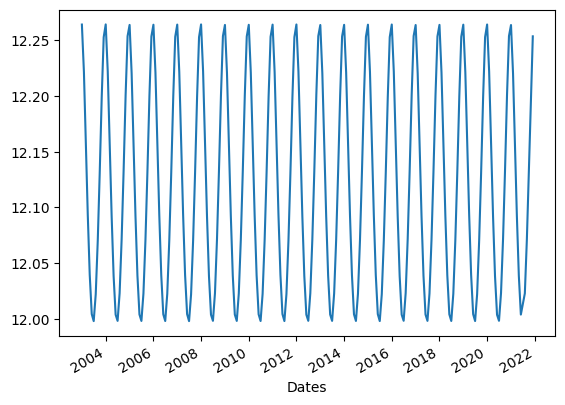

In [66]:
TM_ChlaSST.Dirr.plot()

In [67]:
TM_ChlaSST['PPeu'] = 0.66125 * TM_ChlaSST['Popt'] * (TM_ChlaSST['par'] / (TM_ChlaSST['par'] + 4.1)) * TM_ChlaSST['zeu'] * TM_ChlaSST['Chla'] * TM_ChlaSST['Dirr']

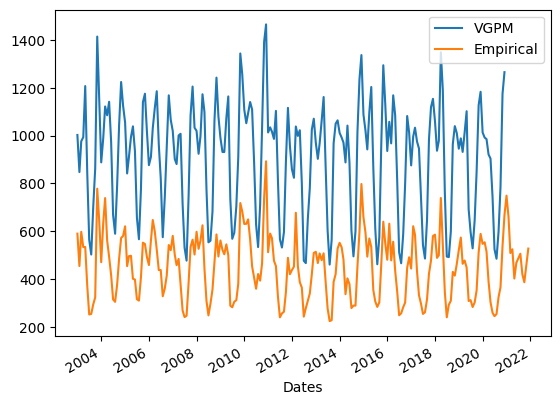

In [71]:
TM_ChlaSST['PPeu'].plot(label='VGPM')

TM_ChlaSST['PP' ].plot(label='Empirical')
plt.legend()


# PART 3
## Tasks

### 0.1 save the output as Excel .csv

### 0.2 load the output with proper index

### 1. How much carbon is accumulated through primary productivity by the whole surface of the global ocean over a year?

- the data represent an **average day** of a month (due to monthly average of Chlorophyll a from MODIS) 
- the year has 365 days
- ocean area 361 * 10$^{12}$ m$^{2}$
- 1 Pg (petagramm) = 10$^{15}$ g

In [38]:
TM_ChlaSST.PPeu.mean()

914.7273441316182

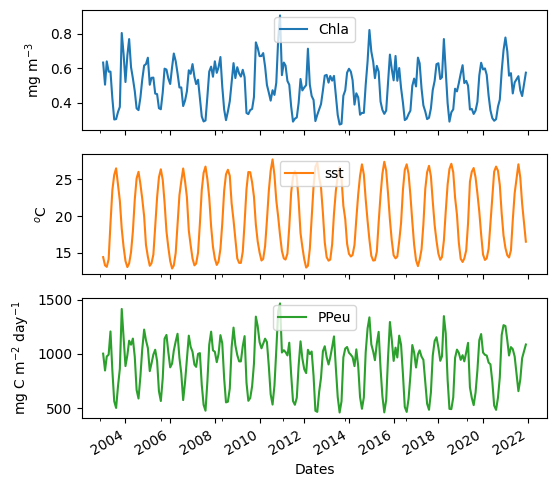

In [39]:
units = {
    'Chla': 'mg m$^{-3}$',
    'sst': '$^o$C', 
    'PPeu': 'mg C m$^{-2}$ day$^{-1}$'
}

labels = units.keys()

axs = TM_ChlaSST[labels].plot(subplots=True, figsize=(6, 6)); 
# _, axs = plt.subplots(3, 1, figsize=(6,6), tight_layout=True)

for ax, lab in zip(axs, labels):
    # TM_ChlaSST[[lab]].plot(ax=ax)
    ax.legend(loc='upper center')
    ax.set_ylabel(units[lab])


### 2. How well the two models Eppley's and VGPM match?

- compute the coefficient of determination (R$^2$)
- compute root-mean-square error (RMSE)
- compute bias
- comment on the one-to-one graph (below)

Text(0, 0.5, 'Empirical')

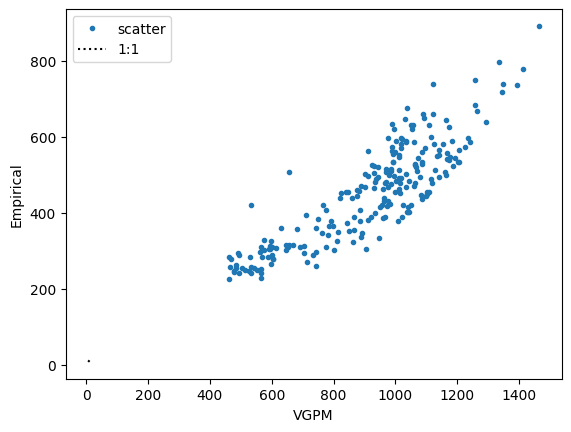

In [40]:
ax = TM_ChlaSST.plot(x='PPeu', y='PP', style='.', label='scatter')
lims = [7, 17]
ax.plot(lims, lims, 'k:', label='1:1')
plt.legend()
ax.set_xlabel('VGPM')
ax.set_ylabel('Empirical')

### 3. Compare sea (SST) and air (Ta) temperature

- sea temperature is from MODIS and is already downloaded ``TM_ChlaSST.sst``
- download `Temperature_height_above_ground` from CFSV2 (source of PAR)
- compare SST and Ta
- **how is temperature included in the VGPM?**